In [1]:
%matplotlib inline
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import numpy as np
import parflow as pf
from parflow.tools.io import write_pfb, read_pfb
import xarray as xr
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xskillscore as xs

In [2]:
#create color maps to use in figures
#maps of hydraulic conductivity (k-values) are in a yellow-orange-red scheme
k_colors = ['#ffffcc', '#fff1a9','#fee288','#fecb67', '#fead4a','#fd903d','#fc612f','#f03523','#d9131f','#b90026','#880026']
k_cmap = ListedColormap(k_colors)

#maps of water table depth (wtd) are in a yellow-green-blue scheme
wtd_colors = [mcolors.to_rgba('#ffffe5'),mcolors.to_rgba('#f1faba'),mcolors.to_rgba('#d7efb3'),mcolors.to_rgba('#aedfb6'),
                mcolors.to_rgba('#76cabc'),mcolors.to_rgba('#46b8c3'),mcolors.to_rgba('#289cc1'),mcolors.to_rgba('#1f78b4'),
                mcolors.to_rgba('#2352a3'),mcolors.to_rgba('#233390'),mcolors.to_rgba('#081d58')]

cmap_name = 'wtd_cmap'
wtd_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, wtd_colors, N=12)

#metrics (percent difference, pd and spearman's rho, sr) are in the color map viridis
#the color maps are reversed however so that yellow equates to poor and dark blue equates to good performance
perc_diff_colors = ['#fde725','#bddf26','#7cd250','#46c06f','#24aa83','#20928c','#297b8e','#33638d','#3f4889','#440154']#viridis 10R
pd_cmap = ListedColormap(perc_diff_colors)
sr_colors = ['#440154','#3f4889','#33638d','#297b8e','#20928c','#24aa83','#46c06f','#7cd250','#bddf26','#fde725']#viridis 10R
sr_cmap = ListedColormap(sr_colors)

#difference plots are in a red-yellow-blue color scheme
#cmap_name = 'diff_colors'
#diff_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, diff_colors, N=9)

#geologic unit plots use a catagorical color map meant to highlight the difference and boundaries of different geologic units
colors = mpl.colormaps['tab10'].colors
hex_colors = [mcolors.rgb2hex(color) for color in colors]
hex_colors = ['black','#1f77b4','#17becf','#d62728','#ff7f0e','gold','#9467bd','#e377c2','#7f7f7f']
geo_unit_cmap = mcolors.LinearSegmentedColormap.from_list('cat_colors', hex_colors, N = 9)

In [ ]:
mod_num = 5
header = True
run_type = "_logK" #_recipK, _logK, _latlon
sub_type = ""
write_dir = f"/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model{mod_num}{run_type}/" #recipK_css_pme75_ani10" #logK_css_pme75_ani10

lake_mask = np.flip(pf.read_pfb('/home/at8471/c1_inversion/ml_training/inputs/c1_great_lakes_masked.pfb').squeeze(),axis = 0)
lake_mask_1d = lake_mask.flatten()

test_inds = [5, 11, 15, 20, 23, 33, 34, 38, 40, 49]

In [5]:
in_vars = ['pme', 'wtd', 'topo_index', 'elev', 'slope_x', 'slope_y']
out_vars = ['ksat']

ds = xr.open_dataset('../inputs/conus_steady_state_parflow.nc').load() #to get topo_index and elev vars

In [6]:
ksat_ens = xr.open_dataset('../inputs/ani10_ef_PmE75_wtd.Ksat.sx.sy.pme.zarr', engine='zarr')
ksat_ens['topo_index'] = ds['TopoIndex']
ksat_ens['elev'] = ds['elev']
ksat_ens['lake_mask'] = xr.DataArray(lake_mask, dims = ('y','x'))

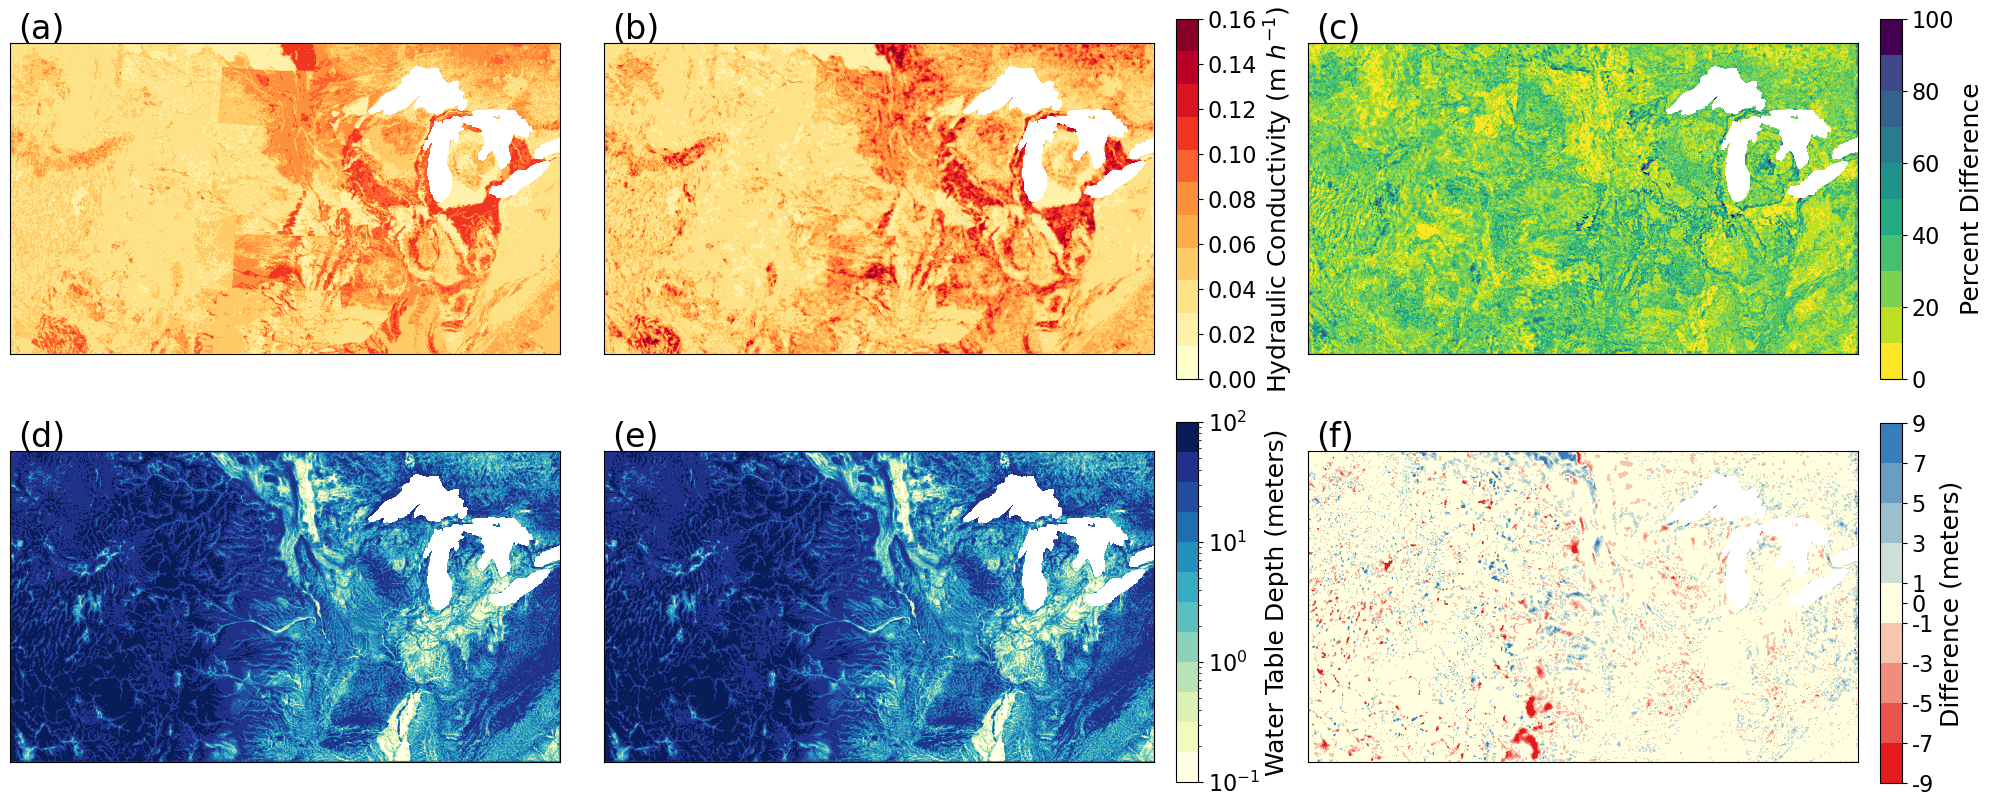

In [7]:
#make figure 2 (combined representative K/WTD)
ind = 20
obsv_ksat = ksat_ens['ksat'].isel(n=ind)
obsv_wtd = ksat_ens['wtd'].isel(n=ind)

pred_ksat = np.flip(read_pfb(f"{write_dir}kpred_test_mem{ind}.pfb").squeeze(), axis = 0)
pred_wtds = np.load(f'../inputs/last_wtd.npy')#3 is the spot for ens member 20 (5, 11, 15, 20, 23, 33, 34, 38, 40, 49
pred_wtd = np.flip(pred_wtds[3,:,:], axis = 0)

abs_diffK = abs(obsv_ksat - pred_ksat)
perc_diffK = (abs(obsv_ksat - pred_ksat)/((obsv_ksat + pred_ksat)/2)) * 100

diffWTD = obsv_wtd - pred_wtd
perc_diffWTD = (abs(obsv_wtd - pred_wtd)/((obsv_wtd + pred_wtd)/2)) * 100

fig, axs = plt.subplots(2, 3, figsize=(22, 12))
ax1, ax2, ax3, ax4, ax5, ax6 = axs.flatten()

im = ax1.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, obsv_ksat), vmin = 0, vmax = .16, cmap = k_cmap)
#ax1.set_title(f'Observed Ksat for test Ind: {ind}', fontsize = 16)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')

im = ax2.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, pred_ksat), vmin = 0, vmax = .16, cmap = k_cmap)
#ax2.set_title(f'Predicted Ksat for test Ind: {ind}', fontsize = 16)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')

im2 = ax3.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, perc_diffK), vmin = 0, vmax = 100, cmap = pd_cmap)
#ax3.set_title(f'Percent Difference in Ksat for test Ind: {ind}', fontsize = 16)

ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('')
ax3.set_ylabel('')

ax1.set_position([0.05, 0.43, 0.25, 0.45])
ax2.set_position([0.32, 0.43, 0.25, 0.45])
ax3.set_position([0.64, 0.43, 0.25, 0.45])

colorbar_text = 'Hydraulic Conductivity (' + r'm $h^{-1}$' + ')'
cbar_ax = fig.add_axes([0.58, 0.505, 0.01, 0.3])
cbar_ax.tick_params(labelsize=16)
fig.colorbar(im, cax=cbar_ax)
colorbar = fig.colorbar(im, cax=cbar_ax)
colorbar.set_label(f'{colorbar_text}', fontsize=18)  

cbar_ax2 = fig.add_axes([0.9, 0.505, 0.01, 0.3])
cbar_ax2.tick_params(labelsize=16)
colorbar2 = fig.colorbar(im2, cax=cbar_ax2)
colorbar2.set_label('Percent Difference', fontsize=18)  

im3 = ax4.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, obsv_wtd), norm=LogNorm(vmin = .1, vmax = 100), cmap = wtd_cmap)

ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_xlabel('')
ax4.set_ylabel('')

im3 = ax5.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, pred_wtd), norm=LogNorm(vmin = .1, vmax = 100), cmap = wtd_cmap)

ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_xlabel('')
ax5.set_ylabel('')

cbar_ax3 = fig.add_axes([0.58, 0.169, 0.01, 0.3])
cbar_ax3.tick_params(labelsize=16)
fig.colorbar(im3, cax=cbar_ax3)
colorbar3 = fig.colorbar(im3, cax=cbar_ax3)
colorbar3.set_label(f'Water Table Depth (meters)', fontsize=18)  

im4 = ax6.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, diffWTD), vmin = -9, vmax = 9, cmap = diff_cmap)

ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_xlabel('')
ax6.set_ylabel('')

ax4.set_position([0.05, 0.09, 0.25, 0.45])
ax5.set_position([0.32, 0.09, 0.25, 0.45])
ax6.set_position([0.64, 0.09, 0.25, 0.45])

cbar_ax4 = fig.add_axes([0.9, 0.168, 0.01, 0.3])
cbar_ax4.tick_params(labelsize=16)
colorbar4 = fig.colorbar(im4, cax=cbar_ax4)
ticks = [-9,-7, -5, -3, -1, 0, 1, 3, 5, 7,9]
tick_labels = [str(val) for val in ticks]  # Convert ticks to strings

colorbar4.set_ticks(ticks)
colorbar4.set_ticklabels(tick_labels)
colorbar4.set_label('Difference (meters)', fontsize=18)  

labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Add labels to the upper left corner of each subplot
for ax, label in zip([ax1, ax2, ax3, ax4, ax5, ax6], labels):
    # Add text in the upper left corner
    ax.text(
        0.015,  # x-coordinate: close to the left
        1.1,  # y-coordinate: close to the top
        label,  # The label
        transform=ax.transAxes,  # Use the axis coordinate system
        fontsize=24,  # Font size
        va='top',  # Vertical alignment (top)
        ha='left'  # Horizontal alignment (left)
    )

plt.savefig(f'/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model{mod_num}{run_type}{sub_type}/figure2.png', format='png', dpi=400)
plt.show()

In [8]:
#domain math supported by figure 2
domain_size = 1888 * 3342
perc_diffK_20 = np.sum(np.where(perc_diffK <= 20,1, 0))
domain_less_20 = perc_diffK_20/domain_size #0.5051260789743278

perc_diffK_40 = np.sum(np.where(perc_diffK <= 40,1, 0))
domain_less_40 = perc_diffK_40/domain_size #0.7646240009027376

abs_diffWTD = abs(obsv_wtd - pred_wtd)
wtd_less_1m = np.sum(np.where(abs_diffWTD <= 1,1, 0))
domain_less_1m = wtd_less_1m/domain_size #0.7744076735234154

wtd_less_10m = np.sum(np.where(abs_diffWTD <= 10,1, 0))
domain_less_10m = wtd_less_10m/domain_size #0.994289423769386

In [9]:
# generate arrays for figure 3
test_inds = [5, 11, 15, 20, 23, 33, 34, 38, 40, 49]
#create perc diff arr for K and WTD (fig 3a/3c)
for counter, ind in enumerate(test_inds):   
    obsv_ksat = ksat_ens['ksat'].isel(n=ind)
    obsv_wtd = ksat_ens['wtd'].isel(n=ind)
    
    pred_ksat = np.flip(read_pfb(f"{write_dir}kpred_test_mem{ind}.pfb").squeeze(), axis = 0)
    pred_wtds = np.load(f'../inputs/last_wtd.npy')#3 is the spot for ens member 20 (5, 11, 15, 20, 23, 33, 34, 38, 40, 49
    pred_wtd = np.flip(pred_wtds[counter,:,:], axis = 0)

    perc_diffK = (abs(obsv_ksat - pred_ksat)/((obsv_ksat + pred_ksat)/2)) * 100
    perc_diffWTD = (abs(obsv_wtd - pred_wtd)/((obsv_wtd + pred_wtd)/2)) * 100
    
    if ind == 5: 
        perc_diff_arrK = perc_diffK
        perc_diff_arrWTD = perc_diffWTD
    else: 
        perc_diff_arrK = perc_diff_arrK + perc_diffK
        perc_diff_arrWTD = perc_diff_arrWTD + perc_diffWTD

#calculate mean perc diff K and WTD(fig 3a/3c)
mean_perc_diff_arrK = perc_diff_arrK/10
mean_perc_diff_arrWTD = perc_diff_arrWTD/10

#create the 1d arrays for the histograms (fig 3b/3d)
test_k_unnorm = xr.open_dataset(f'{write_dir}/test_k_unnorm.nc')
obsvK = test_k_unnorm['ksat'][:,:,:]
predK = test_k_unnorm['predK'][:,:,:]

obsvWTD = ksat_ens['wtd'].isel(n=[5, 11, 15, 20, 23, 33, 34, 38, 40, 49])[:,:,:]
predWTD = np.load(f'../inputs/last_wtd.npy')

obsvK_1d = obsvK.values.ravel()
predK_1d = predK.values.ravel()

obsvWTD_1d = obsvWTD.values.ravel()
predWTD_1d = predWTD.ravel()


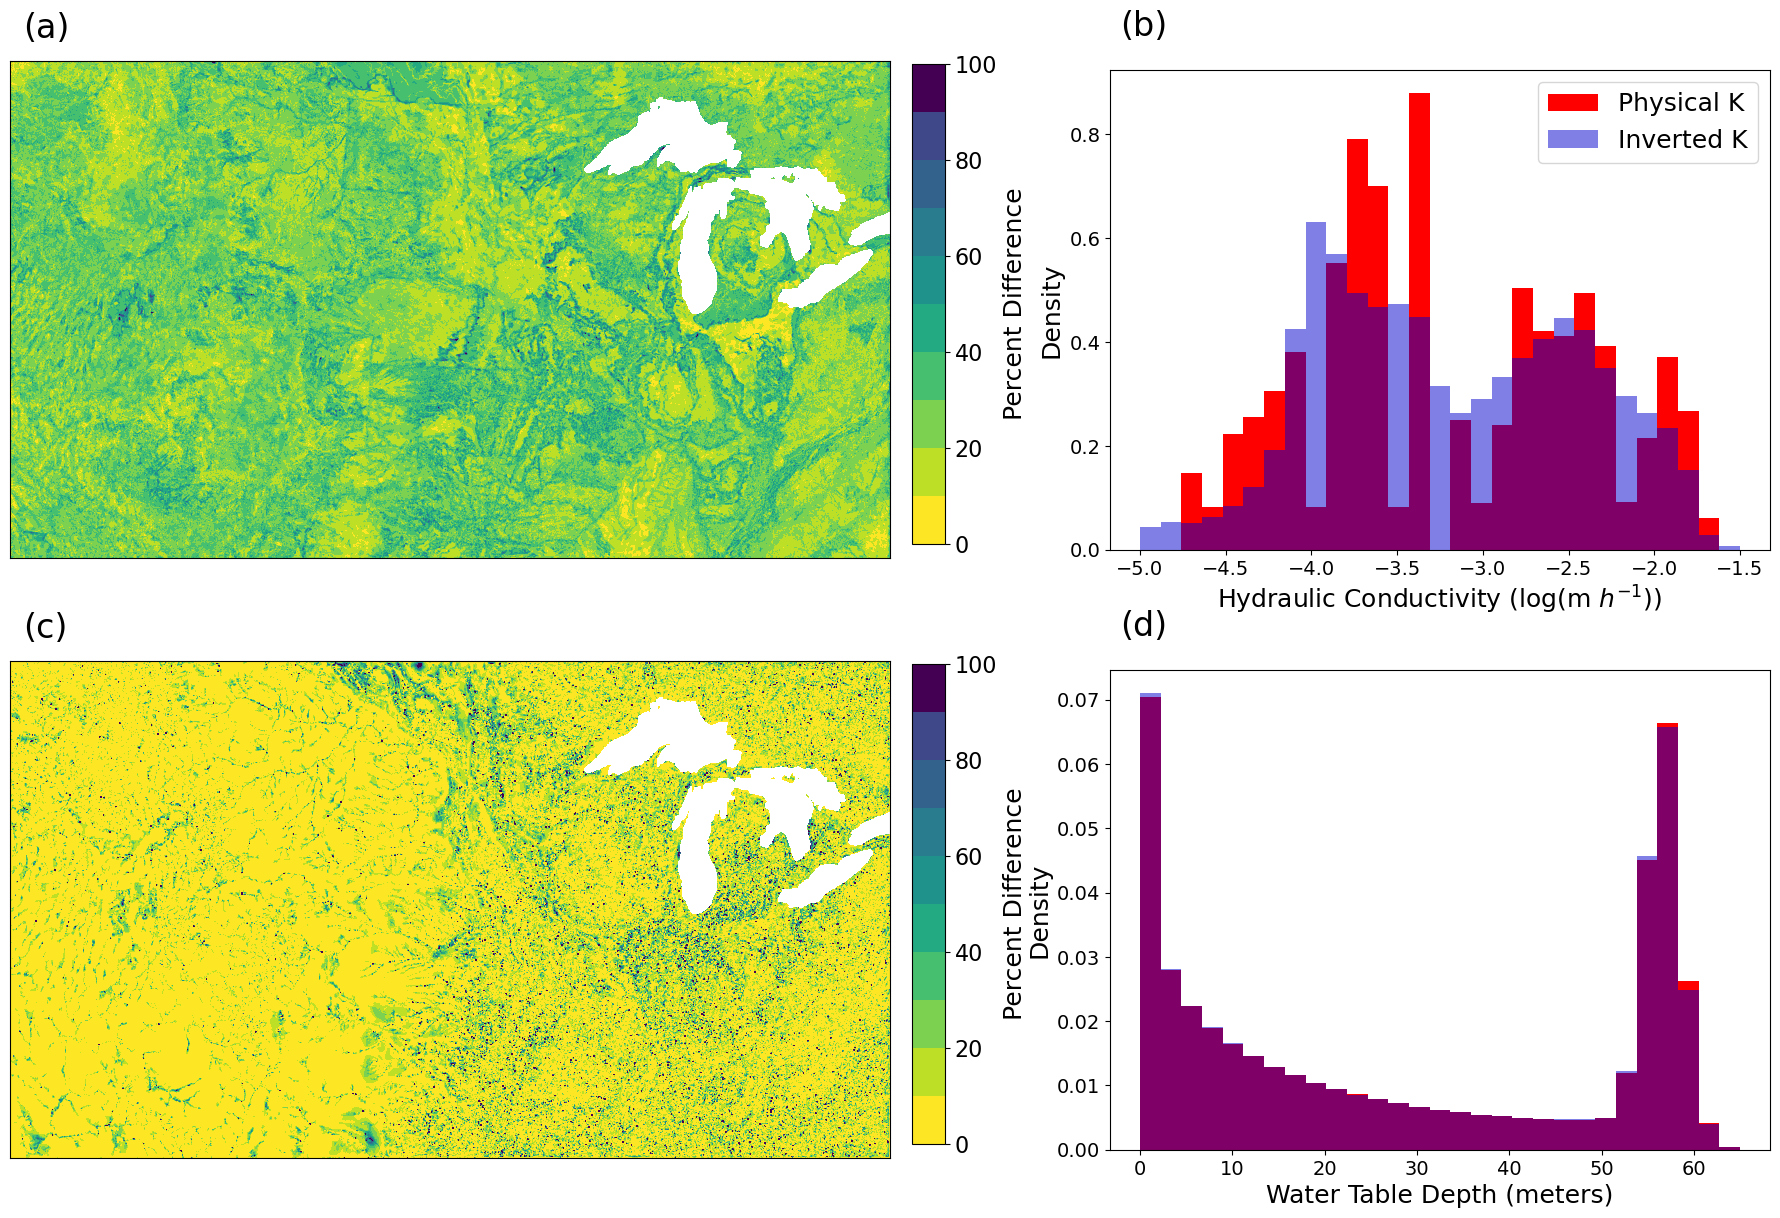

In [14]:
#figure 3
fig, axs = plt.subplots(2, 2, figsize=(22, 12))
ax1, ax2, ax3, ax4 = axs.flatten()

im1 = ax1.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, mean_perc_diff_arrK), vmin = 0, vmax = 100, cmap = pd_cmap)

#im2 = sns.kdeplot(obsvK_1d, ax = ax2, color = "red", log_scale = True, lw = 2)
#im2 = sns.kdeplot(predK_1d, ax = ax2, color = "blue", log_scale = True, lw = 2)

im2 = ax2.hist(np.log(obsvK_1d),bins=np.linspace(-5,-1.5,30),color='red', label = "Physical K",density=True)
im2 = ax2.hist(np.log(predK_1d),bins=np.linspace(-5,-1.5,30),color='mediumblue', label = "Inverted K", alpha = 0.5,density=True)
ax2.legend(fontsize=18)
#im2 = ax2.hist(obsvK_1d,bins=np.linspace(.001,.25,15),color='red', label = "Physical K", histtype='step', lw=2)
#im2 = ax2.hist(predK_1d,bins=np.linspace(.001,.25,15),color='mediumblue', label = "Inverted K", histtype='step', lw=2)

im3 = ax3.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, mean_perc_diff_arrWTD), vmin = 0, vmax = 100, cmap = pd_cmap)

im4 = ax4.hist(obsvWTD_1d,bins=np.linspace(0,65,30),color='red', label = "Physical WTD",density=True)
im4 = ax4.hist(predWTD_1d,bins=np.linspace(0,65,30),color='mediumblue', label = "Inverted WTD", alpha = 0.5,density=True)

ax1.set_position([0.05, 0.52, 0.4, 0.45])
ax2.set_position([0.55, 0.545, 0.3, 0.4])
ax3.set_position([0.05, 0.02, 0.4, 0.45])
ax4.set_position([0.55, 0.045, 0.3, 0.4])

cbar_ax = fig.add_axes([0.46, 0.55, 0.015, 0.4])
cbar_ax.tick_params(labelsize=16)
fig.colorbar(im1, cax=cbar_ax)
colorbar = fig.colorbar(im1, cax=cbar_ax)
colorbar.set_label('Percent Difference', fontsize=18)  

cbar_ax3 = fig.add_axes([0.46, 0.05, 0.015, 0.4])
cbar_ax3.tick_params(labelsize=16)
colorbar3 = fig.colorbar(im3, cax=cbar_ax3)
colorbar3.set_label('Percent Difference', fontsize=18)  

labels = ['(a)','(c)']

# Add labels to the upper left corner of each subplot
for ax, label in zip([ax1,ax3], labels):
    # Add text in the upper left corner
    ax.text(
        0.015,  # x-coordinate: close to the left
        1.1,  # y-coordinate: close to the top
        label,  # The label
        transform=ax.transAxes,  # Use the axis coordinate system
        fontsize=24,  # Font size
        va='top',  # Vertical alignment (top)
        ha='left'  # Horizontal alignment (left)
    )
labels = ['(b)','(d)']
for ax, label in zip([ax2,ax4], labels):
    # Add text in the upper left corner
    ax.text(
        0.015,  # x-coordinate: close to the left
        1.125,  # y-coordinate: close to the top
        label,  # The label
        transform=ax.transAxes,  # Use the axis coordinate system
        fontsize=24,  # Font size
        va='top',  # Vertical alignment (top)
        ha='left'  # Horizontal alignment (left)
    )
    
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')

ax2.set_xlabel('Hydraulic Conductivity (log(' + r'm $h^{-1}$' + '))', fontsize=18)
ax2.set_ylabel('Density', fontsize=18)
ax2.tick_params(axis='x', labelsize=14) 
ax2.tick_params(axis='y', labelsize=14) 
#ax2.set_xscale('log')

ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('')
ax3.set_ylabel('')

ax4.set_xlabel('Water Table Depth (meters)', fontsize=18)
ax4.set_ylabel('Density', fontsize=18)
ax4.tick_params(axis='x', labelsize=14) 
ax4.tick_params(axis='y', labelsize=14) 

plt.savefig(f'/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model{mod_num}{run_type}{sub_type}/figure3.png', format='png', dpi=400)
plt.show()

In [11]:
#domain math supported by figure 3
domain_size = 1888 * 3342
perc_diffK_20 = np.sum(np.where(mean_perc_diff_arrK <= 20,1, 0))
domain_less_20 = perc_diffK_20/domain_size #0.5051260789743278
print(f"Percent of Domain with K Perc Diff less than 20: {domain_less_20}")

perc_diffK_40 = np.sum(np.where(mean_perc_diff_arrK <= 40,1, 0))
domain_less_40 = perc_diffK_40/domain_size #0.7646240009027376
print(f"Percent of Domain with K Perc Diff less than 40: {domain_less_40}")

perc_diffWTD_20 = np.sum(np.where(mean_perc_diff_arrWTD <= 20,1, 0))
domain_less_20 = perc_diffWTD_20/domain_size #0.5051260789743278
print(f"Percent of Domain with WTD Perc Diff less than 20: {domain_less_20}")

perc_diffWTD_40 = np.sum(np.where(mean_perc_diff_arrWTD <= 40,1, 0))
domain_less_40 = perc_diffWTD_40/domain_size #0.7646240009027376

print(f"Percent of Domain with WTD Perc Diff less than 40: {domain_less_40}")

Percent of Domain with K Perc Diff less than 20: 0.40141204901155303
Percent of Domain with K Perc Diff less than 40: 0.8333143149844303
Percent of Domain with WTD Perc Diff less than 20: 0.8529480659607056
Percent of Domain with WTD Perc Diff less than 40: 0.9384772261611336


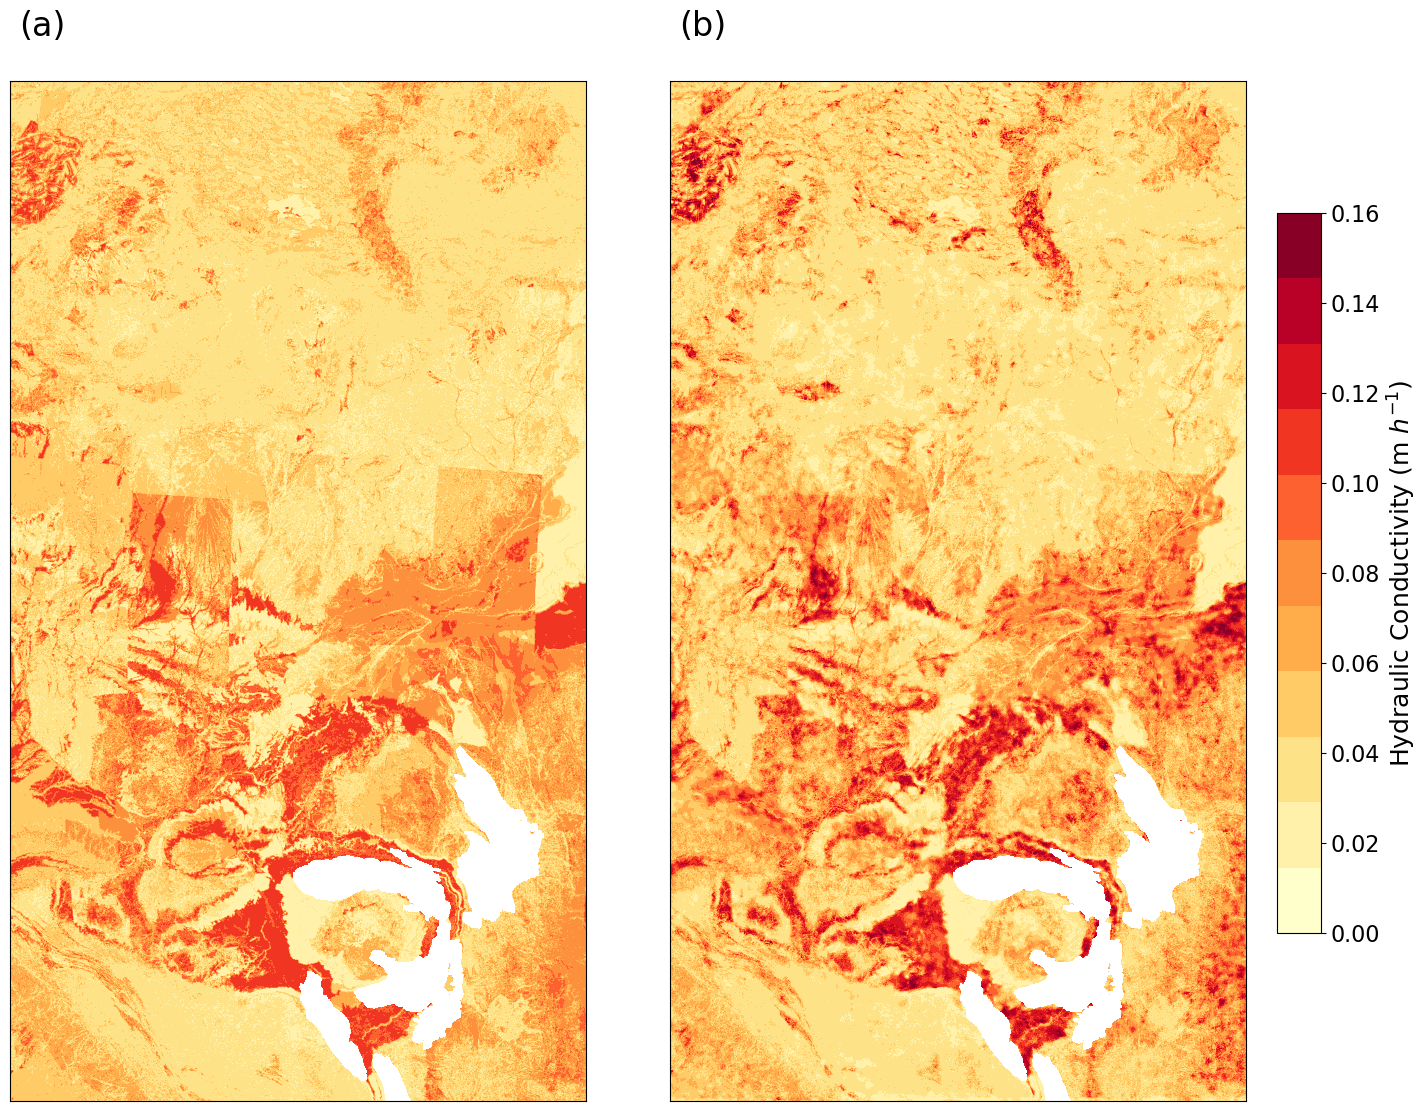

In [11]:
#figure 4a and b
ksat_ens = xr.open_dataset('../inputs/ani10_ef_PmE75_wtd.Ksat.sx.sy.pme.zarr', engine='zarr')
ksat_ens['topo_index'] = ds['TopoIndex']
ksat_ens['elev'] = ds['elev']
ksat_ens['lake_mask'] = xr.DataArray(lake_mask, dims = ('y','x'))

ksat_ens = ksat_ens.transpose('n','x', 'y')
ksat_ens = ksat_ens.isel(y=slice(None, None, -1)) #clockwise 90
obsvK = ksat_ens['ksat'].isel(n=20)

predK = np.flip(read_pfb('/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model5_logK_rotate_clock90/kpred_test_mem20.pfb'), axis = 1)
predK = np.flip(np.transpose(predK), axis=1)

fig, axs = plt.subplots(1, 2, figsize=(22, 12))
ax1, ax2 = axs.flatten()

im = ax1.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, obsvK ), vmin = 0, vmax = 0.16, cmap = k_cmap)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')

im = ax2.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, predK[:,:,0]), vmin = 0, vmax = 0.16, cmap = k_cmap)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')

ax1.set_position([0.05, 0.05, 0.35, 0.85])
ax2.set_position([0.35, 0.05, 0.35, 0.85])

cbar_ax = fig.add_axes([0.67, 0.19, 0.02, 0.6])
cbar_ax.tick_params(labelsize=16)
fig.colorbar(im, cax=cbar_ax)
colorbar = fig.colorbar(im, cax=cbar_ax)
colorbar_text = 'Hydraulic Conductivity (' + r'm $h^{-1}$' + ')'
colorbar.set_label(f'{colorbar_text}', fontsize=18)  

labels = ['(a)','(b)']

# Add labels to the upper left corner of each subplot
for ax, label in zip([ax1,ax2], labels):
    # Add text in the upper left corner
    ax.text(
        0.015,  # x-coordinate: close to the left
        1.07,  # y-coordinate: close to the top
        label,  # The label
        transform=ax.transAxes,  # Use the axis coordinate system
        fontsize=24,  # Font size
        va='top',  # Vertical alignment (top)
        ha='left'  # Horizontal alignment (left)
    )

plt.savefig(f'/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model{mod_num}{run_type}{sub_type}/figure4a_b.png', format='png', dpi=400)

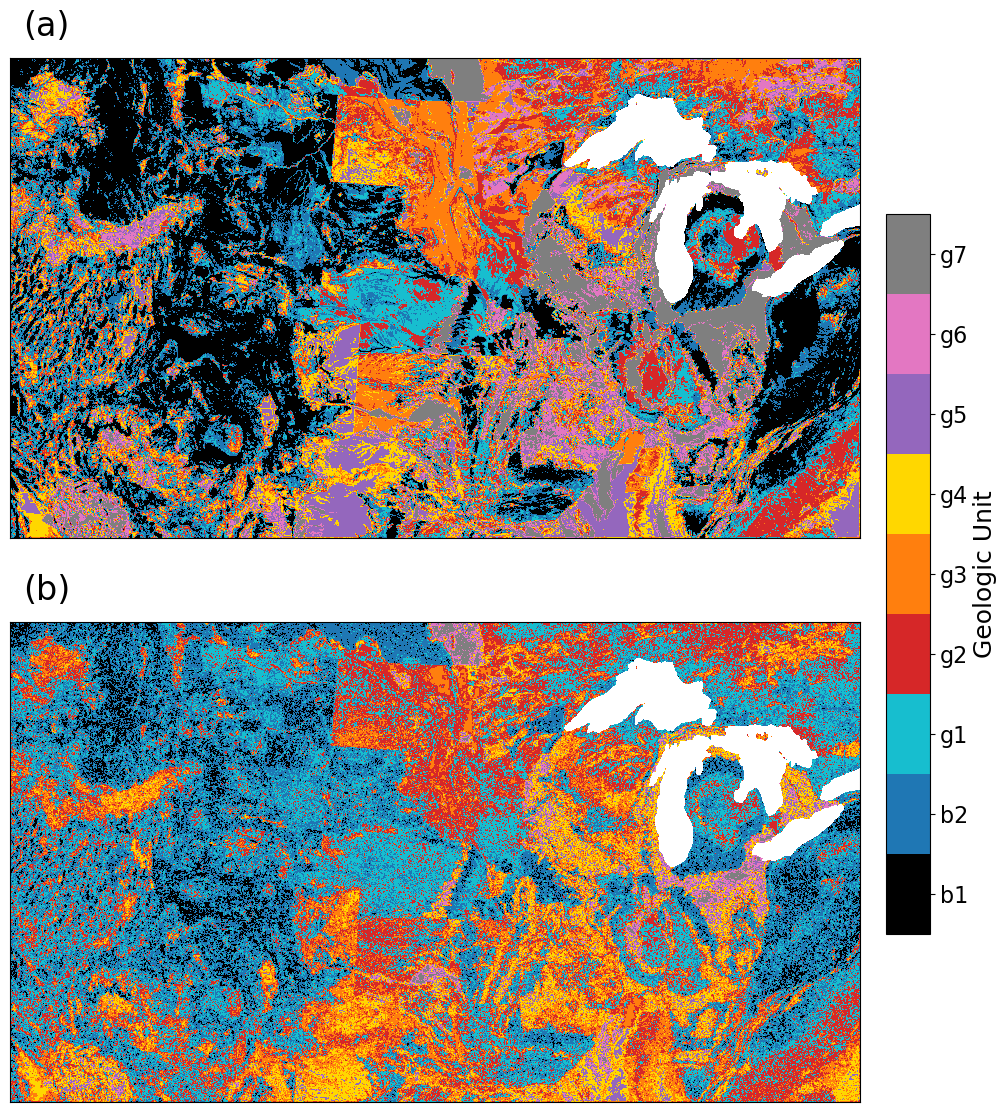

In [12]:
#figure 4c and d
ksat_ens = xr.open_dataset('../inputs/ani10_ef_PmE75_wtd.Ksat.sx.sy.pme.zarr', engine='zarr')
ksat_ens['topo_index'] = ds['TopoIndex']
ksat_ens['elev'] = ds['elev']
ksat_ens['lake_mask'] = xr.DataArray(lake_mask, dims = ('y','x'))
colors = mpl.colormaps['tab10'].colors
hex_colors = [mcolors.rgb2hex(color) for color in colors]
hex_colors = ['black','#1f77b4','#17becf','#d62728','#ff7f0e','gold','#9467bd','#e377c2','#7f7f7f']
cat_cmap = mcolors.LinearSegmentedColormap.from_list('cat_colors', hex_colors, N = 9)

ind_orig = np.flip(read_pfb('/home/at8471/c1_inversion/ml_training/inputs/grid3d.v3.pfb'), axis = 1)
ind_flip = np.flip(read_pfb('/home/at8471/subset_pfensemble_wf/produce_indicator_ens/outputs/edge_rand_flip/250iter_0.005perc_flip.pfb'), axis = 1)

fig, axs = plt.subplots(2, 1, figsize=(22, 12))
ax1, ax2 = axs.flatten()

im = ax1.imshow(np.where(ksat_ens['lake_mask']==0,np.nan,ind_orig[0,:,:]), cmap = geo_unit_cmap)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')

im = ax2.imshow(np.where(ksat_ens['lake_mask']==0,np.nan,ind_flip[0,:,:]), cmap = geo_unit_cmap, vmin = 19, vmax = 28)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')

ax1.set_position([0.05, 0.52, 0.75, 0.4])
ax2.set_position([0.05, 0.05, 0.75, 0.4])

cbar_ax = fig.add_axes([0.63, 0.19, 0.02, 0.6])
cbar_ax.tick_params(labelsize=16)
fig.colorbar(im, cax=cbar_ax)
colorbar = fig.colorbar(im, cax=cbar_ax)
colorbar.set_label('Geologic Unit', fontsize=18)  
ticks = [19.5, 20.5, 21.5, 22.5,23.5, 24.5, 25.5, 26.5, 27.5] 
colorbar.set_ticks(ticks)
colorbar.set_ticklabels(['b1', 'b2', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7'])

labels = ['(a)','(b)']

# Add labels to the upper left corner of each subplot
for ax, label in zip([ax1,ax2], labels):
    # Add text in the upper left corner
    ax.text(
        0.015,  # x-coordinate: close to the left
        1.1,  # y-coordinate: close to the top
        label,  # The label
        transform=ax.transAxes,  # Use the axis coordinate system
        fontsize=24,  # Font size
        va='top',  # Vertical alignment (top)
        ha='left'  # Horizontal alignment (left)
    )

plt.savefig(f'/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model{mod_num}{run_type}{sub_type}/indicator_SI.png', format='png', dpi=150)

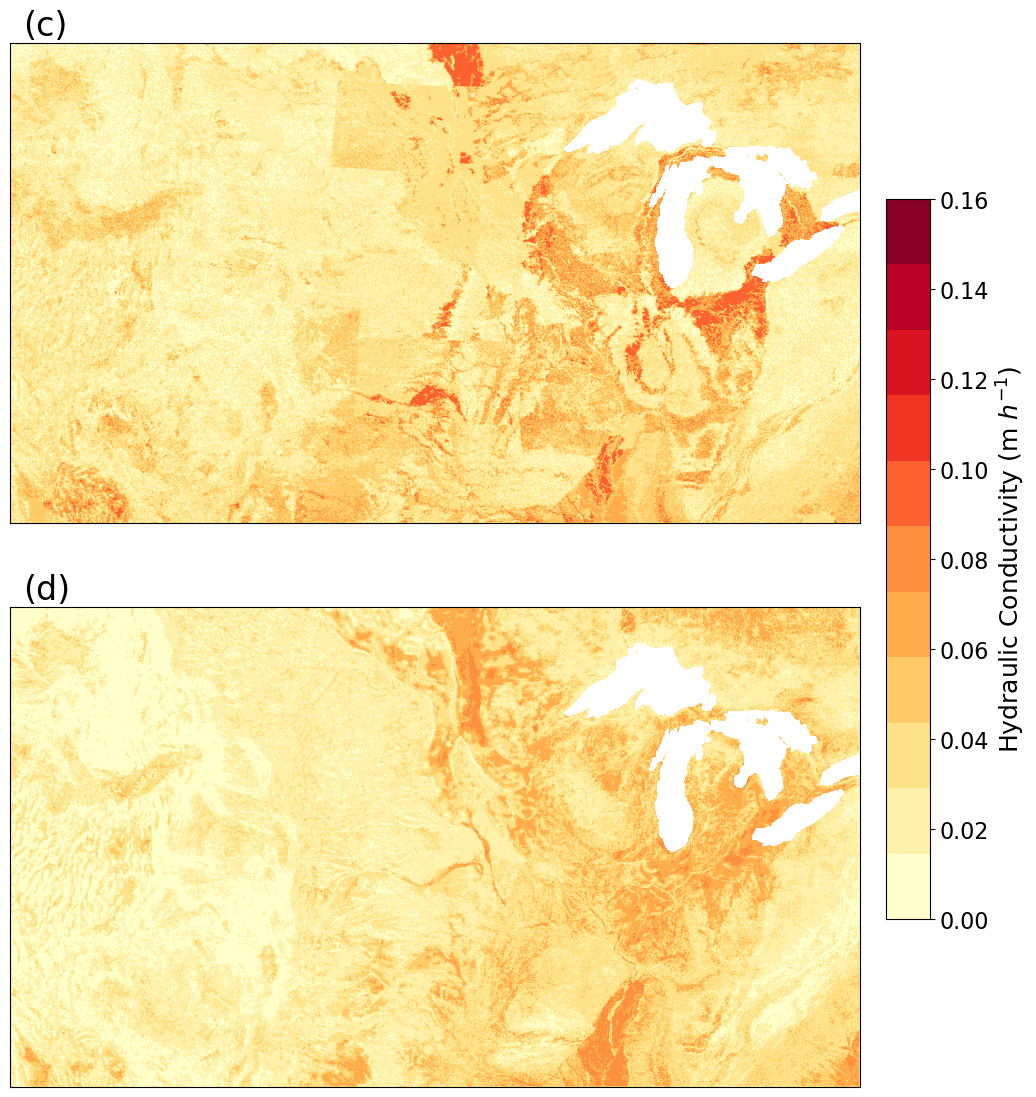

In [13]:
#figure 4e and f
ksat_ens = xr.open_dataset('../inputs/ani10_ef_PmE75_wtd.Ksat.sx.sy.pme.zarr', engine='zarr')
ksat_ens['topo_index'] = ds['TopoIndex']
ksat_ens['elev'] = ds['elev']
ksat_ens['lake_mask'] = xr.DataArray(lake_mask, dims = ('y','x'))

obsvK = np.load('/home/at8471/c1_inversion/ml_training/inputs/250iter_005_kmap.npy')
predK = np.flip(read_pfb('/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model5_logK/kpred_oos_250.pfb'), axis = 1)


fig, axs = plt.subplots(2, 1, figsize=(22, 12))
ax1, ax2 = axs.flatten()

im = ax1.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, obsvK), vmin = 0, vmax = 0.16, cmap = k_cmap)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')

im = ax2.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, predK[0,:,:]), vmin = 0, vmax = 0.16, cmap = k_cmap)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')

ax1.set_position([0.05, 0.52, 0.75, 0.4])
ax2.set_position([0.05, 0.05, 0.75, 0.4])

cbar_ax = fig.add_axes([0.63, 0.19, 0.02, 0.6])
cbar_ax.tick_params(labelsize=16)
fig.colorbar(im, cax=cbar_ax)
colorbar = fig.colorbar(im, cax=cbar_ax)
colorbar_text = 'Hydraulic Conductivity (' + r'm $h^{-1}$' + ')'
colorbar.set_label(f'{colorbar_text}', fontsize=18)  

labels = ['(c)','(d)']

# Add labels to the upper left corner of each subplot
for ax, label in zip([ax1,ax2], labels):
    # Add text in the upper left corner
    ax.text(
        0.015,  # x-coordinate: close to the left
        1.07,  # y-coordinate: close to the top
        label,  # The label
        transform=ax.transAxes,  # Use the axis coordinate system
        fontsize=24,  # Font size
        va='top',  # Vertical alignment (top)
        ha='left'  # Horizontal alignment (left)
    )

plt.savefig(f'/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model{mod_num}{run_type}{sub_type}/figure4c_d.png', format='png', dpi=400)

In [15]:
#creating figure 5 (spearman's rho) data
test_k_unnorm = xr.open_dataset(f'{write_dir}/test_k_unnorm.nc')
srK = xs.pearson_r(test_k_unnorm['ksat'], test_k_unnorm['predK'], dim='n')

obsvWTD = ksat_ens['wtd'].isel(n=[5, 11, 15, 20, 23, 33, 34, 38, 40, 49])
predWTD_arr = np.load(f'../inputs/last_wtd.npy')
predWTD_arr2 = np.flip(predWTD_arr[:,:,:], axis = 1)

predWTD = xr.Dataset(
    {
        "predWTD": (("n", "y","x"), predWTD_arr2)  # Define data variable with dimensions
    },
    coords={
        "n": np.arange(predWTD_arr2.shape[0]),  # Coordinates for dimension 1
        "y": np.arange(predWTD_arr2.shape[1]),  # Coordinates for dimension 2
        "x": np.arange(predWTD_arr2.shape[2]),  # Coordinates for dimension 2
    },
)

srWTD = xs.pearson_r(obsvWTD, predWTD, dim='n')
srWTD = srWTD.to_array()

/home/at8471/.conda/envs/ml_analysis/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/at8471/.conda/envs/ml_analysis/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


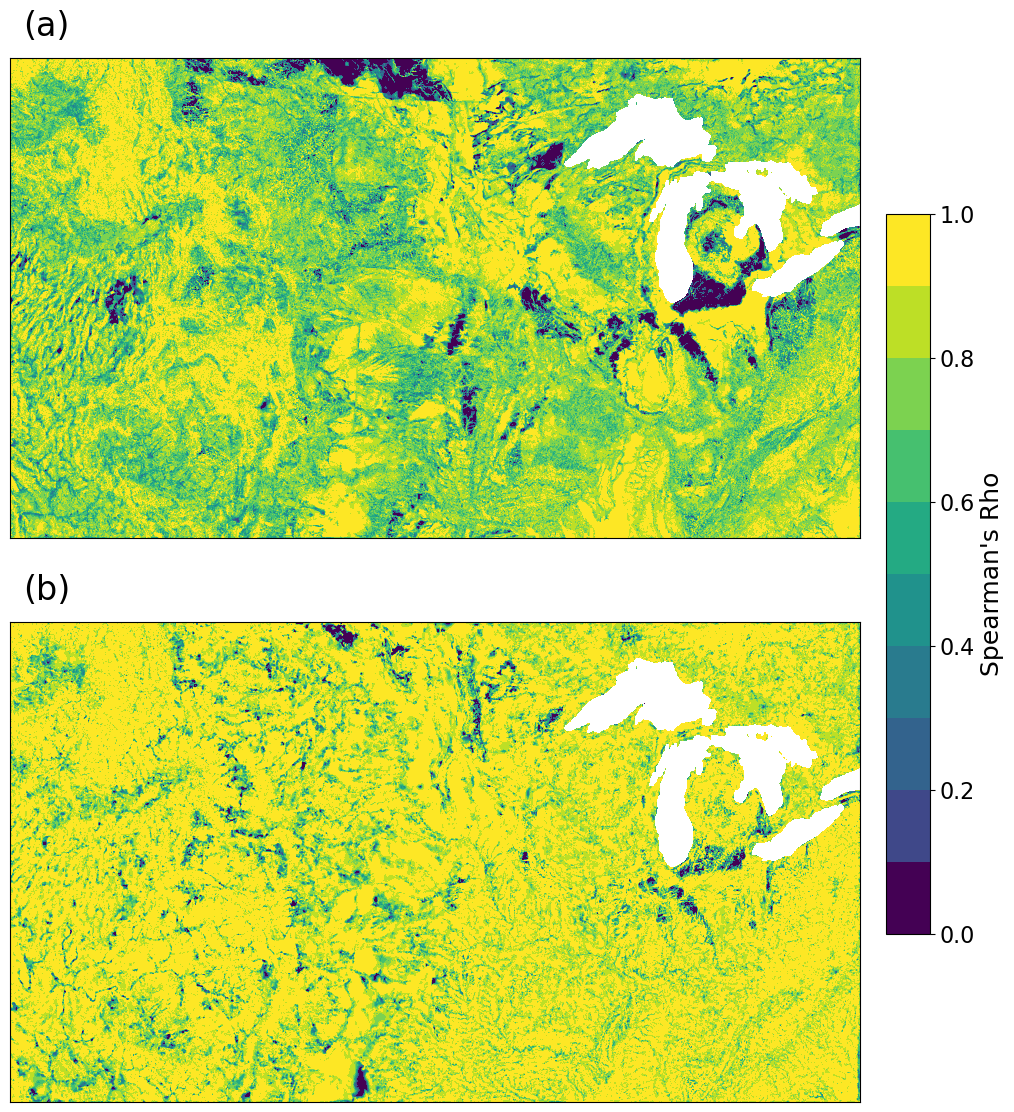

In [16]:
#creating figure 5
fig, axs = plt.subplots(2, 1, figsize=(22, 12))
ax1, ax2 = axs.flatten()

im = ax1.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, srK), vmin = 0, vmax = 1, cmap = sr_cmap)

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')

im = ax2.imshow(np.where(ksat_ens['lake_mask']==0,np.nan, srWTD[0,:,:]), vmin = 0, vmax = 1, cmap = sr_cmap)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')

ax1.set_position([0.05, 0.52, 0.75, 0.4])
ax2.set_position([0.05, 0.05, 0.75, 0.4])

cbar_ax = fig.add_axes([0.63, 0.19, 0.02, 0.6])
cbar_ax.tick_params(labelsize=16)
fig.colorbar(im, cax=cbar_ax)
colorbar = fig.colorbar(im, cax=cbar_ax)
colorbar.set_label('Spearman\'s Rho', fontsize=18)  

labels = ['(a)','(b)']

# Add labels to the upper left corner of each subplot
for ax, label in zip([ax1,ax2], labels):
    # Add text in the upper left corner
    ax.text(
        0.015,  # x-coordinate: close to the left
        1.1,  # y-coordinate: close to the top
        label,  # The label
        transform=ax.transAxes,  # Use the axis coordinate system
        fontsize=24,  # Font size
        va='top',  # Vertical alignment (top)
        ha='left'  # Horizontal alignment (left)
    )

plt.savefig(f'/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model{mod_num}{run_type}{sub_type}/figure5.png', format='png', dpi=400)

In [18]:
#domain math supported by figure 5
domain_size = 1888 * 3342
SR_70K = np.sum(np.where(srK >= 0.7,1, 0))
domain_less_70 = SR_70K/domain_size #0.5051260789743278
print(f"Percent of Domain with K SR greater  than 0.7: {domain_less_70}")

SR_70WTD = np.sum(np.where(srWTD >= 0.7,1, 0))
domain_less_70 = SR_70WTD/domain_size #0.7646240009027376
print(f"Percent of Domain with WTD SR greater than 0.7: {domain_less_70}")

Percent of Domain with K SR greater  than 0.7: 0.7321259217559768
Percent of Domain with WTD SR greater than 0.7: 0.8811527528426092


In [3]:
#getting data for figure 6
write_dir = f"/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis" 
mod_num = 5
run_type1 = "logK_pme_minus_" 
run_type2 = "logK_pme_plus_" #recipK, logK, latlon
scalar_list = [0.05,0.1, 0.25]

test_k_unnorm = xr.open_dataset(f'{write_dir}/model{mod_num}_logK/test_k_unnorm.nc')['predK'].values.ravel()
test_k_unnorm1 = xr.open_dataset(f'{write_dir}/model{mod_num}_{run_type1}{scalar_list[0]}/test_k_unnorm.nc')['predK'].values.ravel()
test_k_unnorm2 = xr.open_dataset(f'{write_dir}/model{mod_num}_{run_type1}{scalar_list[1]}/test_k_unnorm.nc')['predK'].values.ravel()
test_k_unnorm3 = xr.open_dataset(f'{write_dir}/model{mod_num}_{run_type1}{scalar_list[2]}/test_k_unnorm.nc')['predK'].values.ravel()
test_k_unnorm4 = xr.open_dataset(f'{write_dir}/model{mod_num}_{run_type2}{scalar_list[0]}/test_k_unnorm.nc')['predK'].values.ravel()
test_k_unnorm5 = xr.open_dataset(f'{write_dir}/model{mod_num}_{run_type2}{scalar_list[1]}/test_k_unnorm.nc')['predK'].values.ravel()
test_k_unnorm6 = xr.open_dataset(f'{write_dir}/model{mod_num}_{run_type2}{scalar_list[2]}/test_k_unnorm.nc')['predK'].values.ravel()

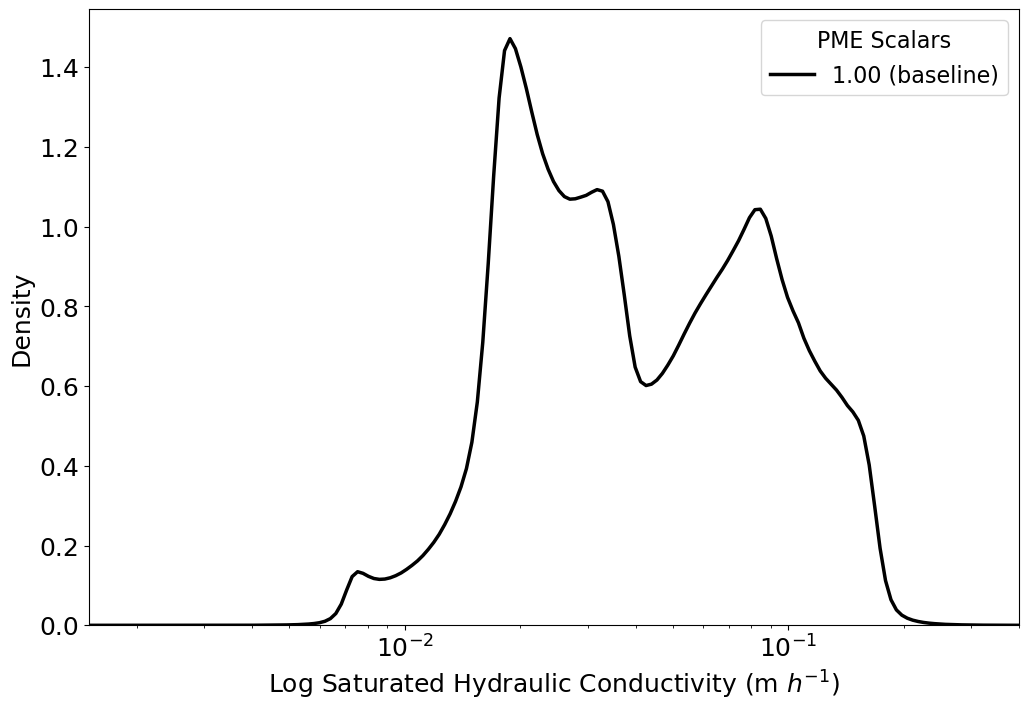

In [6]:
xlabel_text = 'Log Saturated Hydraulic Conductivity (' + r'm $h^{-1}$' + ')'

plt.figure(figsize=(12, 8))

sns.kdeplot(test_k_unnorm, color='black', log_scale = True, lw=2.5,label = "1.00 (baseline)")
plt.gca().set_xlim(0.0015, .4) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(f'{xlabel_text}', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xscale('log')
plt.legend(title='PME Scalars', fontsize=16, title_fontsize=16)

plt.savefig(f'/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model5_logK/figure6_bl.png', format='png', dpi=400)

plt.show()

In [ ]:
xlabel_text = 'Log Saturated Hydraulic Conductivity (' + r'm $h^{-1}$' + ')'

plt.figure(figsize=(12, 8))
sns.kdeplot(test_k_unnorm, color='black', log_scale = True, lw=2.5,label = "1.00 (baseline)")
sns.kdeplot(test_k_unnorm3, color='#a50026', log_scale = True, lw=1,label = "0.75 (driest)")
sns.kdeplot(test_k_unnorm2, color='#ea5739', log_scale = True, lw=1,label = "0.90")
sns.kdeplot(test_k_unnorm1, color='#fdbd6f', log_scale = True, lw=1,label = "0.95")

plt.gca().set_xlim(0.0015, .4) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(f'{xlabel_text}', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xscale('log')
plt.legend(title='PME Scalars', fontsize=16, title_fontsize=16)

plt.savefig(f'/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model5_logK/figure6_bld.png', format='png', dpi=400)

plt.show()

In [ ]:
xlabel_text = 'Log Saturated Hydraulic Conductivity (' + r'm $h^{-1}$' + ')'

plt.figure(figsize=(12, 8))

sns.kdeplot(test_k_unnorm, color='black', log_scale = True, lw=2.5,label = "1.00 (baseline)")
sns.kdeplot(test_k_unnorm4, color='#bfe3ef', log_scale = True, lw=1,label = "1.05")
sns.kdeplot(test_k_unnorm5, color='#679ec9', log_scale = True, lw=1,label = "1.10")
sns.kdeplot(test_k_unnorm6, color='#313695', log_scale = True, lw=1,label = "1.25 (wettest)")
plt.gca().set_xlim(0.0015, .4) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(f'{xlabel_text}', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xscale('log')
plt.legend(title='PME Scalars', fontsize=16, title_fontsize=16)

plt.savefig(f'/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model5_logK/figure6_blw.png', format='png', dpi=400)

plt.show()

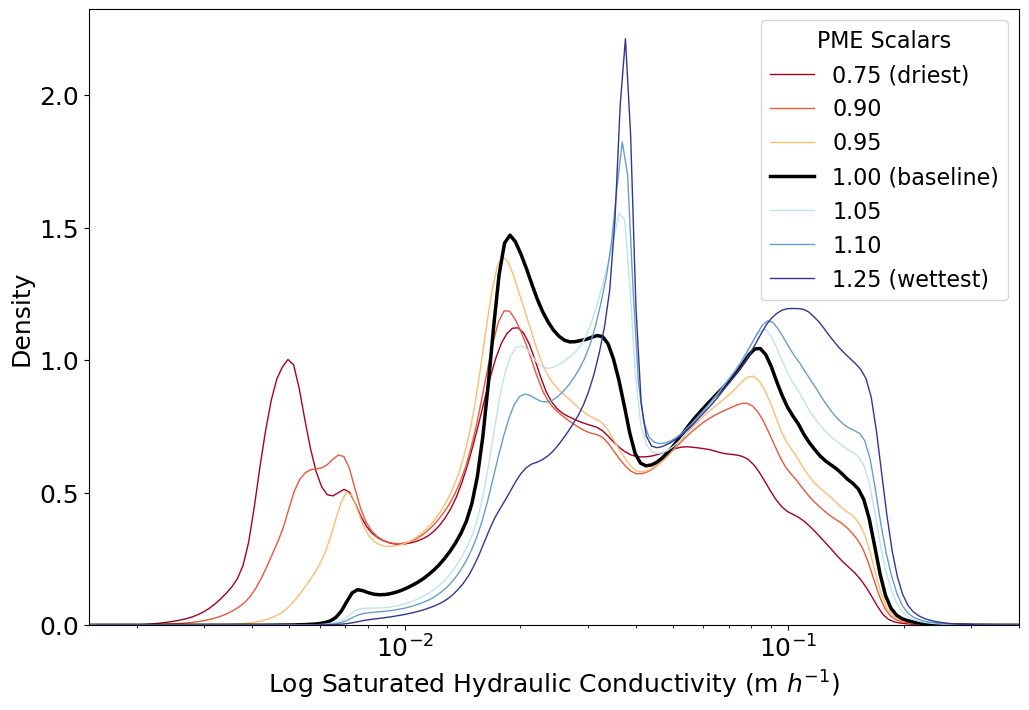

In [4]:
#create figure 6
xlabel_text = 'Log Saturated Hydraulic Conductivity (' + r'm $h^{-1}$' + ')'

plt.figure(figsize=(12, 8))

sns.kdeplot(test_k_unnorm3, color='#a50026', log_scale = True, lw=1,label = "0.75 (driest)")
sns.kdeplot(test_k_unnorm2, color='#ea5739', log_scale = True, lw=1,label = "0.90")
sns.kdeplot(test_k_unnorm1, color='#fdbd6f', log_scale = True, lw=1,label = "0.95")
sns.kdeplot(test_k_unnorm, color='black', log_scale = True, lw=2.5,label = "1.00 (baseline)")
sns.kdeplot(test_k_unnorm4, color='#bfe3ef', log_scale = True, lw=1,label = "1.05")
sns.kdeplot(test_k_unnorm5, color='#679ec9', log_scale = True, lw=1,label = "1.10")
sns.kdeplot(test_k_unnorm6, color='#313695', log_scale = True, lw=1,label = "1.25 (wettest)")
plt.gca().set_xlim(0.0015, .4) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(f'{xlabel_text}', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.xscale('log')
plt.legend(title='PME Scalars', fontsize=16, title_fontsize=16)

plt.savefig(f'/home/at8471/c1_inversion/ml_training/outputs/css_pme75_ani10_ens_analysis/model5_logK/figure6_all.png', format='png', dpi=400)

plt.show()